__Author: Haozhou__


In [2]:
#Covid-19
import pandas as pd
import requests
import re
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [3]:
#1>

#Preparation
webpage = requests.get("https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports").text
page = BeautifulSoup(webpage, "lxml")
alist = page("a")
hrefs = []
for each in alist:
    if each.has_attr("href"):
        hrefs.append(each["href"])
rawstart = "https://raw.githubusercontent.com"
links = []
for each in hrefs:
    if (re.search(".*-2020.csv$", each)):
        links.append(rawstart + re.sub("blob/master", "master", each))


In [4]:
#Scrap
datas = []
for each in links:
    temp = pd.read_csv(each)
    datas.append(temp[(temp == "Hong Kong").any(axis = 1)])

In [5]:
#2>

#Deal with data collected
hongkong = pd.concat(datas, axis = 0, ignore_index=True)
datetime = [each[-14:-4] for each in links]

#Do some modification
hongkong["Province/State"] = hongkong["Province/State"].mode()[0]
hongkong["Country/Region"] = hongkong["Country_Region"].mode()[0]
hongkong["Confirmed"] = hongkong["Confirmed"].fillna(0)
hongkong["Deaths"] = hongkong["Deaths"].fillna(0)
hongkong["Active"] = hongkong["Active"].fillna(0)
hongkong["Recovered"] = hongkong["Recovered"].fillna(0)
hongkong["Last Update"] = hongkong["Last Update"].fillna(hongkong["Last_Update"])
hongkong["Latitude"] = hongkong["Lat"].mean()
hongkong["Longitude"] = hongkong["Long_"].mean()
hongkong["Incident_Rate"] = hongkong["Incident_Rate"].fillna(hongkong["Incidence_Rate"])
hongkong["Case_Fatality_Ratio"] = hongkong["Case_Fatality_Ratio"].fillna(hongkong["Case-Fatality_Ratio"])
hongkong["Combined_Key"] = hongkong["Combined_Key"].fillna(hongkong["Combined_Key"].mode()[0])

result = hongkong.drop(columns = ["Country_Region", "Province_State", "FIPS", "Admin2", "Incidence_Rate", "Last_Update", "Lat", "Long_", "Case-Fatality_Ratio"])
result.insert(5, 'Active', result.pop("Active"))
result.insert(0, 'Date', datetime)
result["Last Update"] = pd.to_datetime(result["Last Update"])
result["Date"] = pd.to_datetime(result["Date"])
result = result.sort_values(by = ["Date"])
result

,Date,Province/State,Country/Region,Last Update,Confirmed,Deaths,Active,Recovered,Latitude,Longitude,Combined_Key,Incident_Rate,Case_Fatality_Ratio
0,2020-01-22,Hong Kong,China,2020-01-22 17:00:00,0.0,0.0,0.0,0.0,22.3,114.2,"Hong Kong, China",NaN,NaN
1,2020-01-23,Hong Kong,China,2020-01-23 17:00:00,2.0,0.0,0.0,0.0,22.3,114.2,"Hong Kong, China",NaN,NaN
2,2020-01-24,Hong Kong,China,2020-01-24 17:00:00,2.0,0.0,0.0,0.0,22.3,114.2,"Hong Kong, China",NaN,NaN
3,2020-01-25,Hong Kong,China,2020-01-25 17:00:00,5.0,0.0,0.0,0.0,22.3,114.2,"Hong Kong, China",NaN,NaN
4,2020-01-26,Hong Kong,China,2020-01-26 16:00:00,8.0,0.0,0.0,0.0,22.3,114.2,"Hong Kong, China",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,2020-12-27,Hong Kong,China,2020-12-28 05:22:06,8610.0,137.0,999.0,7474.0,22.3,114.2,"Hong Kong, China",114.846122,1.591173
341,2020-12-28,Hong Kong,China,2020-12-29 05:22:37,8671.0,141.0,1004.0,7526.0,22.3,114.2,"Hong Kong, China",115.659782,1.626110
342,2020-12-29,Hong Kong,China,2020-12-30 05:22:34,8724.0,143.0,965.0,7616.0,22.3,114.2,"Hong Kong, China",116.366733,1.639156
343,2020-12-30,Hong Kong,China,2020-12-31 05:22:49,8778.0,147.0,909.0,7722.0,22.3,114.2,"Hong Kong, China",117.087022,1.674641


In [6]:
#Save as csv

result.to_csv("Covid19_HongKong.csv")

Text(0.5, 1.0, 'Accumulated Covid-19 cases in Hong Kong')

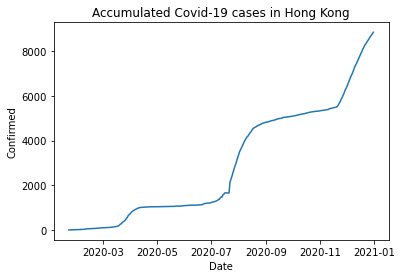

In [7]:
#3>

sns.lineplot(x = result.Date, y = result.Confirmed).set_title("Accumulated Covid-19 cases in Hong Kong")

Text(0.5, 1.0, 'Daily new Covid-19 cases in Hong Kong')

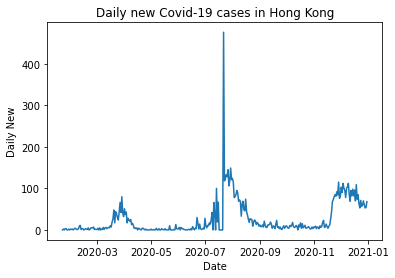

In [8]:
#4>

ylist = [0,]
for i in range(1,len(result)):
    ylist.append(result.iloc[i][4] - result.iloc[i-1][4])

sns.lineplot(x = result.Date, y = ylist).set_ylabel("Daily New")
sns.lineplot().set_title("Daily new Covid-19 cases in Hong Kong")

/opt/anaconda3/envs/Analysis/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Text(0.5, 1.0, 'Predict cases')

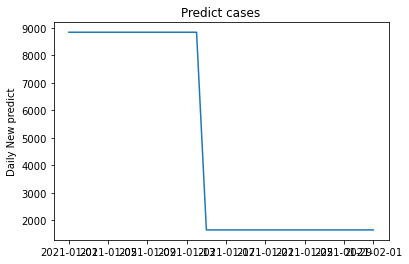

In [81]:
import numpy as np

Xtrain = np.array(list(range(345))).reshape(-1,1)
Ytrain = np.array(result.Confirmed).reshape(-1,1)
clf = svm.SVC(gamma=0.01)
clf.fit(Xtrain , Ytrain)

testtime = pd.date_range("2021-01-01","2021-02-01")
Xtest = np.array(list(range(345,345+32))).reshape(-1,1)
Ypredic = clf.predict(Xtest)

sns.lineplot(x = testtime, y = Ypredic).set_ylabel("Daily New predict")
sns.lineplot().set_title("Predict cases")